<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/Code1_Paddy_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
#import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from functools import partial
import posixpath

from keras import models, regularizers, layers, optimizers, losses, metrics
import keras_cv
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!nvidia-smi

Sun Oct 23 22:50:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab

In [7]:
tf.__version__

'2.9.2'

In [8]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [11]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [12]:
train_dir= 'thesis/dataset/paddy_doctor/train/'
val_dir= 'thesis/dataset/paddy_doctor/val/'
img_size= 224

train_files= posixpath.join(code_runtime, train_dir)
test_files= posixpath.join(code_runtime, val_dir)

train_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="training",
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)

val_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        class_names= labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)


test_datagen= ImageDataGenerator()
test_data= test_datagen.flow_from_directory(test_files,
                                            target_size= (img_size, img_size),
                                            batch_size= 16,
                                            shuffle = False, 
                                            class_mode='categorical')

Found 14302 files belonging to 10 classes.
Using 11442 files for training.
Found 14302 files belonging to 10 classes.
Using 2860 files for validation.
Found 1500 images belonging to 10 classes.


In [13]:
class_names = train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


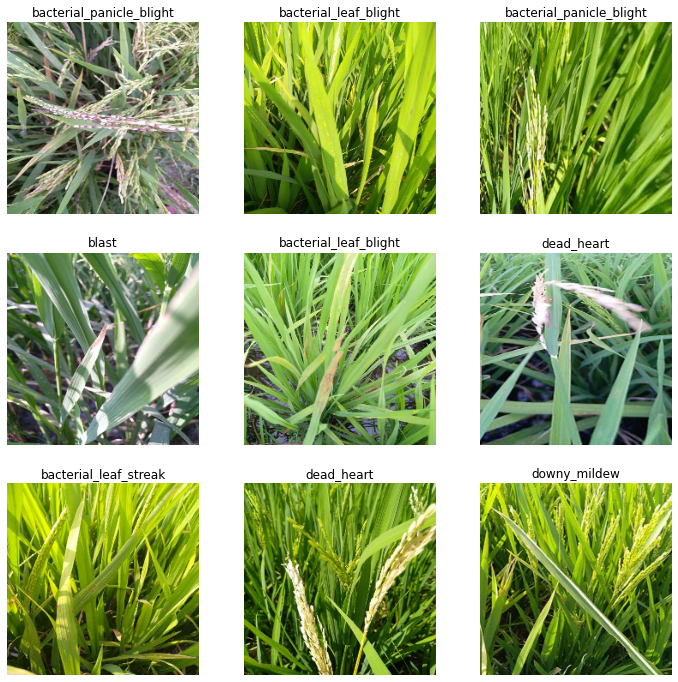

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Augmentation Pipeline

In [68]:
'''
KerasCV allows you to construct production grade custom data augmentation pipelines using
the `keras_cv.layers.RandomAugmentationPipeline` layer. This class operates similarly to
`RandAugment`; selecting a random layer to apply to each image `augmentations_per_image`
times. `RandAugment` can be thought of as a specific case of
`RandomAugmentationPipeline`. In fact, our `RandAugment` implementation inherits from
`RandomAugmentationPipeline` internally.
In this example, we will create a custom `RandomAugmentationPipeline` by removing
`RandomRotation` layers from the standard `RandAugment` policy, and substitutex a
`GridMask` layer in its place.
"""

"""
As a first step, let's use the helper method `RandAugment.get_standard_policy()` to
create a base pipeline.
'''

'\nKerasCV allows you to construct production grade custom data augmentation pipelines using\nthe `keras_cv.layers.RandomAugmentationPipeline` layer. This class operates similarly to\n`RandAugment`; selecting a random layer to apply to each image `augmentations_per_image`\ntimes. `RandAugment` can be thought of as a specific case of\n`RandomAugmentationPipeline`. In fact, our `RandAugment` implementation inherits from\n`RandomAugmentationPipeline` internally.\nIn this example, we will create a custom `RandomAugmentationPipeline` by removing\n`RandomRotation` layers from the standard `RandAugment` policy, and substitutex a\n`GridMask` layer in its place.\n"""\n\n"""\nAs a first step, let\'s use the helper method `RandAugment.get_standard_policy()` to\ncreate a base pipeline.\n'

In [39]:
# Standard policy https://github.com/keras-team/keras-cv/blob/v0.3.4/keras_cv/layers/preprocessing/rand_augment.py#L25

layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude= 0.75, magnitude_stddev= 0.3, seed= 42)
layers

In [41]:
# data augmentation https://keras.io/api/keras_cv/layers/preprocessing/random_augmentation_pipeline/
layers = keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255), geometric= True, magnitude= 0.5, magnitude_stddev= 0.25)
layers1 = layers[4:] + [keras_cv.layers.preprocessing.RandomFlip(mode= 'horizontal'),
                    keras_cv.layers.preprocessing.RandomRotation(factor= .1),
                    keras_cv.layers.preprocessing.MaybeApply(keras_cv.layers.GridMask(ratio_factor= (.0, .3), rotation_factor= (.0,.1), fill_mode= 'gaussian_noise'), .4), 
                    keras_cv.layers.preprocessing.MaybeApply(keras_cv.layers.RandomColorJitter(brightness_factor= .5, contrast_factor= .5, hue_factor= .2, saturation_factor= (.1, .9), value_range= [0, 255]), .4)                  
]

layers1

In [42]:
aug_pipeline= keras_cv.layers.RandomAugmentationPipeline(layers= layers1, augmentations_per_image= 3)

aug_pipeline

In [14]:
# data augmentation
def augment_train_data(images, labels):
  inputs= {"images": images, "labels": labels}
  layers= keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255), geometric= True, magnitude= 0.75, magnitude_stddev= 0.3)
  layers= layers + [keras_cv.layers.preprocessing.RandomFlip(mode= 'horizontal'),
                    keras_cv.layers.preprocessing.RandomRotation(factor= .1, seed= 42),
                    keras_cv.layers.GridMask(ratio_factor= (.0, .3), rotation_factor= (.0,.1), fill_mode= 'gaussian_noise'), 
                    keras_cv.layers.RandomColorJitter(brightness_factor= .5, contrast_factor= .5, hue_factor= .2, saturation_factor= (.1, .9), value_range= [0, 255])]
  aug_pipeline= keras_cv.layers.RandomAugmentationPipeline(layers= layers, augmentations_per_image= 3)
  outputs= aug_pipeline(inputs)
  print(*layers)
  return outputs['images'], outputs['labels']

In [15]:
AUTOTUNE= tf.data.AUTOTUNE
train_aug_ds= train_data.map(augment_train_data, num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds= val_data.prefetch(buffer_size= AUTOTUNE)
test_ds= test_data.prefetch(buffer_size= AUTOTUNE)

<keras_cv.layers.preprocessing.auto_contrast.AutoContrast object at 0x7fd26486e110> <keras_cv.layers.preprocessing.equalization.Equalization object at 0x7fd26ea4d8d0> <keras_cv.layers.preprocessing.solarization.Solarization object at 0x7fd26d750790> <keras_cv.layers.preprocessing.random_color_degeneration.RandomColorDegeneration object at 0x7fd2646a7050> <keras.layers.preprocessing.image_preprocessing.RandomContrast object at 0x7fd26468dbd0> <keras.layers.preprocessing.image_preprocessing.RandomBrightness object at 0x7fd26468d090> <keras_cv.layers.preprocessing.random_shear.RandomShear object at 0x7fd25065ac50> <keras_cv.layers.preprocessing.random_shear.RandomShear object at 0x7fd26a9322d0> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7fd26468d150> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7fd26bea5990> <keras_cv.layers.preprocessing.random_flip.RandomFlip object at 0x7fd26c03d0d0> <keras_cv.layers.preprocessing.rand

AttributeError: ignored

In [31]:
'''
transform_train= alb.Compose([
            alb.Transpose(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.VerticalFlip(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            alb.RandomBrightnessContrast( brightness_limit=(-0.1,0.1),  contrast_limit=(-0.2, 0.2), p=0.5),
            alb.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            alb.CLAHE(p=0.5, clip_limit=(1, 4), tile_grid_size=(12, 12)),
            alb.GridDistortion(p=0.5, num_steps=5, distort_limit=(-0.4, 0.4), interpolation=0, border_mode=2),
            alb.GridDropout(p=0.6, ratio=0.4, holes_number_x=3, holes_number_y=3, random_offset=True)
        ], p= 1.0)

transform_val= alb.Compose([
            alb.Transpose(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.VerticalFlip(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            alb.RandomBrightnessContrast( brightness_limit=(-0.1,0.1),  contrast_limit=(-0.2, 0.2), p=0.5),
            alb.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            alb.CLAHE(p=0.5, clip_limit=(1, 4), tile_grid_size=(12, 12)),
            alb.GridDistortion(p=0.5, num_steps=5, distort_limit=(-0.4, 0.4), interpolation=0, border_mode=2),
            alb.GridDropout(p=0.6, ratio=0.4, holes_number_x=3, holes_number_y=3, random_offset=True)
        ], p= 0.0)

AUTOTUNE = tf.data.experimental.AUTOTUNE
'''

In [32]:
'''
def train_aug_fn(image, img_size):
  data = {"image":image}
  aug_data = transform_train(**data)
  aug_img = aug_data["image"]
  #aug_img = tf.cast(aug_img/255.0, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
  return aug_img

  
def val_aug_fn(image, img_size):
  data = {"image":image}
  aug_data = transform_val(**data)
  aug_img = aug_data["image"]
  #aug_img = tf.cast(aug_img/255.0, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
  return aug_img


def process_data_train(image, label, img_size):
  aug_img = tf.numpy_function(func= train_aug_fn, inp=[image, img_size], Tout=tf.float32)
  return aug_img, label

def process_data_val(image, label, img_size):
  aug_img = tf.numpy_function(func= val_aug_fn, inp=[image, img_size], Tout=tf.float32)
  return aug_img, label

def set_shapes(img, label, img_shape=(img_size,img_size,3)):
  img.set_shape(img_shape)
  label.set_shape([10,])
  return img, label
'''

In [33]:
'''
alb_train_ds= train_data.map(partial(process_data_train, img_size = img_size), num_parallel_calls= AUTOTUNE).prefetch(AUTOTUNE)
alb_train_ds= alb_train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(16)

#spec = tf.TensorSpec(shape=[None, 10], dtype=tf.int32)
#alb_train_ds.element_spec[1]= tf.TensorSpec.from_spec(spec)

alb_train_ds
'''

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None))>

In [ ]:
'''
val_data_ds= val_data.map(partial(process_data_train, img_size = img_size), num_parallel_calls= AUTOTUNE).prefetch(AUTOTUNE)
val_data_ds= val_data_ds.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(16)
val_data_ds
'''

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None))>

## ResNet50 (Final)

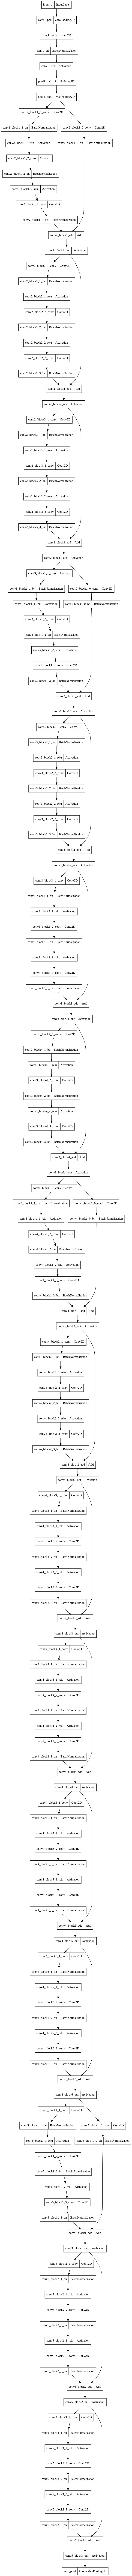

In [16]:
base_model= ResNet50(
    include_top= False,
    weights= 'imagenet',
    input_shape=(img_size, img_size, 3),
    pooling= 'max'
)

plot_model(base_model)

In [64]:
'''
base_model.trainable= False
for layer in base_model.layers:
  if not isinstance(layer, layers.normalization.batch_normalization.BatchNormalization):
    print(layer)
    layer.trainable = True
    '''

'\nbase_model.trainable= False\nfor layer in base_model.layers:\n  if not isinstance(layer, layers.normalization.batch_normalization.BatchNormalization):\n    print(layer)\n    layer.trainable = True\n    '

In [17]:
inputs= tf.keras.Input(shape= (img_size, img_size, 3))
preprocess_layer= tf.keras.applications.resnet50.preprocess_input(inputs)
normalization_layer= tf.keras.layers.Rescaling(scale= 1./127.5, offset= -1)(preprocess_layer)
x= base_model(normalization_layer)
x= tf.keras.layers.Dropout(0.3)(x)
x= tf.keras.layers.Dense(256, activation= 'relu')(x)
x= tf.keras.layers.Dropout(0.25)(x)
outputs= tf.keras.layers.Dense(10, activation= 'softmax')(x)

In [ ]:
model= tf.keras.Model(inputs= inputs, outputs= outputs, name= "resnet50_transfer_learning")

In [41]:
model.summary()

Model: "resnet50_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048

In [43]:
optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= True)

model.compile(
        optimizer = optimizer,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )

In [44]:
print(f"Number of parameters (millions): {model.count_params() / 1e6}.")

Number of parameters (millions): 24.114826.


In [22]:
%%time
n_epochs= 100

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode= 'max')
early_stop_callback= EarlyStopping(monitor='val_accuracy', patience= 5, verbose= False, mode='max')
callbacks_list=[checkpoint_callback, early_stop_callback]


CPU times: user 55 µs, sys: 0 ns, total: 55 µs
Wall time: 59.6 µs


In [46]:
history= model.fit(train_aug_ds,
                    epochs= n_epochs,
                    validation_data= val_ds,
                    callbacks= callbacks_list,
                    verbose= 1)

Epoch 1/100
716/716 [==============================] - ETA: 0s - loss: 2.7143 - accuracy: 0.4005 - f1_score: 0.3969
Epoch 1: val_accuracy improved from -inf to 0.16748, saving model to weights-improvement-01-0.17.hdf5
716/716 [==============================] - 45s 55ms/step - loss: 2.7143 - accuracy: 0.4005 - f1_score: 0.3969 - val_loss: 3.0511 - val_accuracy: 0.1675 - val_f1_score: 0.1044
Epoch 2/100
715/716 [============================>.] - ETA: 0s - loss: 1.0010 - accuracy: 0.6661 - f1_score: 0.6633
Epoch 2: val_accuracy improved from 0.16748 to 0.80874, saving model to weights-improvement-02-0.81.hdf5
716/716 [==============================] - 38s 53ms/step - loss: 1.0010 - accuracy: 0.6661 - f1_score: 0.6633 - val_loss: 0.6004 - val_accuracy: 0.8087 - val_f1_score: 0.8072
Epoch 3/100
716/716 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.8119 - f1_score: 0.8105
Epoch 3: val_accuracy improved from 0.80874 to 0.86538, saving model to weights-improvement-03-

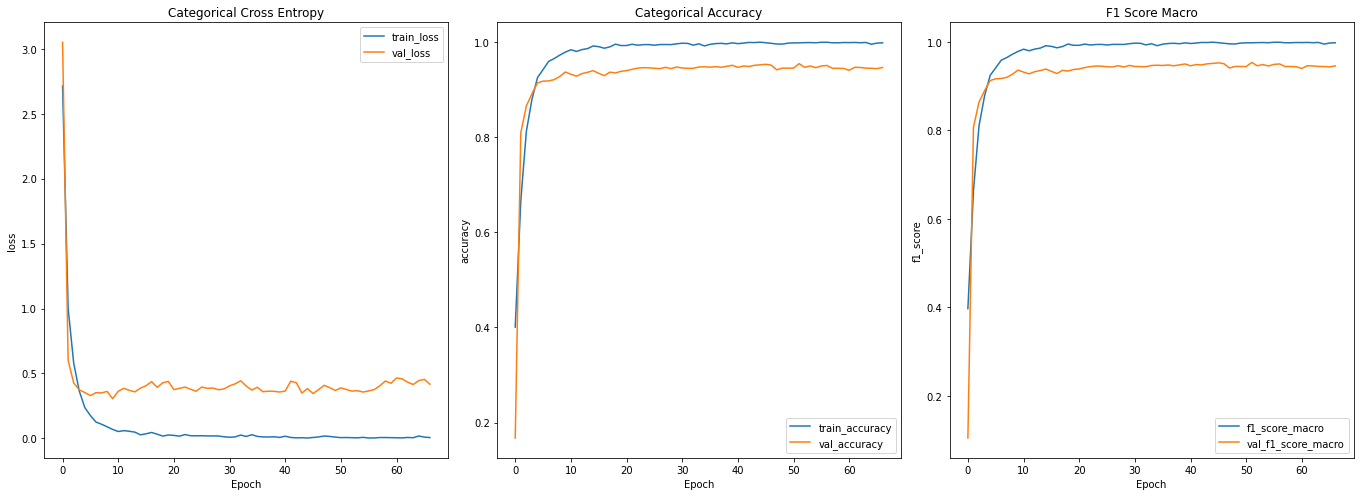

In [55]:
def plot_results(history, epochs, FE_name= "ResNet50", model_name= "ResNet50_model", version= 1):
    import os
    ## Create the dataframe
    data = pd.DataFrame()
    data["Epoch"] = [i for i in range(epochs)]
    data["loss"] = history.history["loss"]
    data["val_loss"] = history.history["val_loss"]
    data["accuracy"] = history.history["accuracy"]
    data["val_accuracy"] = history.history["val_accuracy"]
    data["f1_score"] = history.history["f1_score"]
    data["val_f1_score"] = history.history["val_f1_score"]

    ## Create subplots
    fig, ax= plt.subplots(1, 3, figsize = (19, 7))

    ## plot loss
    sns.lineplot(x= "Epoch", y= "loss", data = data, ax= ax[0])
    sns.lineplot(x= "Epoch", y= "val_loss", data = data, ax= ax[0])
    ax[0].legend(["train_loss", "val_loss"], loc= 'best')
    ax[0].title.set_text("Categorical Cross Entropy")

    ## plot accuracy
    sns.lineplot(x = "Epoch", y = "accuracy", data = data, ax = ax[1])
    sns.lineplot(x = "Epoch", y = "val_accuracy", data = data, ax = ax[1])
    ax[1].legend(["train_accuracy", "val_accuracy"], loc='best')
    ax[1].title.set_text("Categorical Accuracy")

    ## plot f1
    sns.lineplot(x = "Epoch", y = "f1_score", data = data, ax = ax[2])
    sns.lineplot(x = "Epoch", y = "val_f1_score", data = data, ax = ax[2])
    ax[2].legend(["f1_score_macro", "val_f1_score_macro"], loc='best')
    ax[2].title.set_text("F1 Score Macro")


    ## Remove padding
    fig.tight_layout()

plot_results(history, epochs = 67, FE_name = "ResNet50", model_name = "resnet50_transfer_learning")

In [89]:
model.evaluate(test_ds, batch_size= 16, return_dict= True)

94/94 [==============================] - 2s 18ms/step - loss: 0.4145 - accuracy: 0.9553 - f1_score: 0.9552


{'loss': 0.4144630432128906,
 'accuracy': 0.9553333520889282,
 'f1_score': 0.9552358388900757}

In [106]:
# Generating Confusion Matrix and Classification Report
Y_pred= model.predict_generator(test_data, 1500// 16 + 1)
y_pred= np.argmax(Y_pred, axis= 1)
print('Confusion Matrix')
conf_matrix= confusion_matrix(test_data.classes, y_pred)
conf_mat = np.array2string(conf_matrix)
print(conf_matrix)
print("=============================================================================================")
print('Classification Report')
target_names= train_data.class_names
class_rep_vgg = classification_report(test_data.classes, y_pred, target_names=target_names)
print(class_rep_vgg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[134   4   0   4   3   0   1   4   0   0]
 [  0 149   0   0   1   0   0   0   0   0]
 [  0   0 144   1   0   3   0   0   2   0]
 [  0   1   0 146   0   1   0   1   1   0]
 [  2   1   0   2 141   0   1   1   1   1]
 [  0   0   2   0   0 148   0   0   0   0]
 [  0   1   0   5   3   0 135   4   1   1]
 [  0   0   0   2   0   0   0 147   1   0]
 [  0   0   2   0   1   0   0   4 143   0]
 [  0   0   0   2   4   1   1   1   0 141]]
Classification Report
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.99      0.89      0.94       150
   bacterial_leaf_streak       0.96      0.99      0.97       150
bacterial_panicle_blight       0.97      0.96      0.97       150
                   blast       0.90      0.97      0.94       150
              brown_spot       0.92      0.94      0.93       150
              dead_heart       0.97      0.99      0.98       150
            downy_mildew       0.98      0.90      0.94       150
 

In [107]:
model.save('/content/drive/MyDrive/thesis/dataset/paddy_doctor/ResNet50')

## ResNet50 (Exp 1)

In [23]:
optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= False)
model1= tf.keras.Model(inputs= inputs, outputs= outputs, name= "resnet50_exp1")
model1.compile(
        optimizer = optimizer,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )

In [24]:
history1= model1.fit(train_aug_ds,
                    epochs= 100,
                    validation_data= val_ds,
                    callbacks= callbacks_list,
                    verbose= 1)

Epoch 1/100
  5/716 [..............................] - ETA: 46s - loss: 15.0396 - accuracy: 0.1000 - f1_score: 0.0903

InvalidArgumentError: ignored